# Plot the spectrum files from DRAGONS 
This interactive notebook serves as a nice sanity check to visualize the spectrum from files obtained through the DRAGONS data reduction pipeline before continuuing with the normalization. Can also use this notebook to plot continuum normalized data.

In [2]:
import numpy as np
import os 
import glob
import re

import matplotlib.pyplot as plt
import itertools
import sys

%matplotlib notebook

In [13]:
dir_name = '/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/'
star = 'TEST_DATA/Aqu2_776_B_EXAMPLE_OUTPUT/' ## The name of the star directory

In [15]:
spath = dir_name + star + exposures[0]
print(spath)

'/astro/adovgal/SCRIPTS/GHOULS_FIXER_v3/TEST_DATA/Aqu2_776_B_EXAMPLE_OUTPUT/S20240902S0007_002_blue_normrv.xyz'

Un-processed data is .dat, normalized and corrected data is .xyz
Type either: dat or xyz for file to plotxyz
S20240902S0007_002_blue_normrv.xyz
S20240902S0007_002_red_normrv.xyz
S20240902S0008_002_blue_normrv.xyz
S20240902S0008_002_red_normrv.xyz
S20240902S0009_002_blue_normrv.xyz
S20240902S0009_002_red_normrv.xyz


<IPython.core.display.Javascript object>


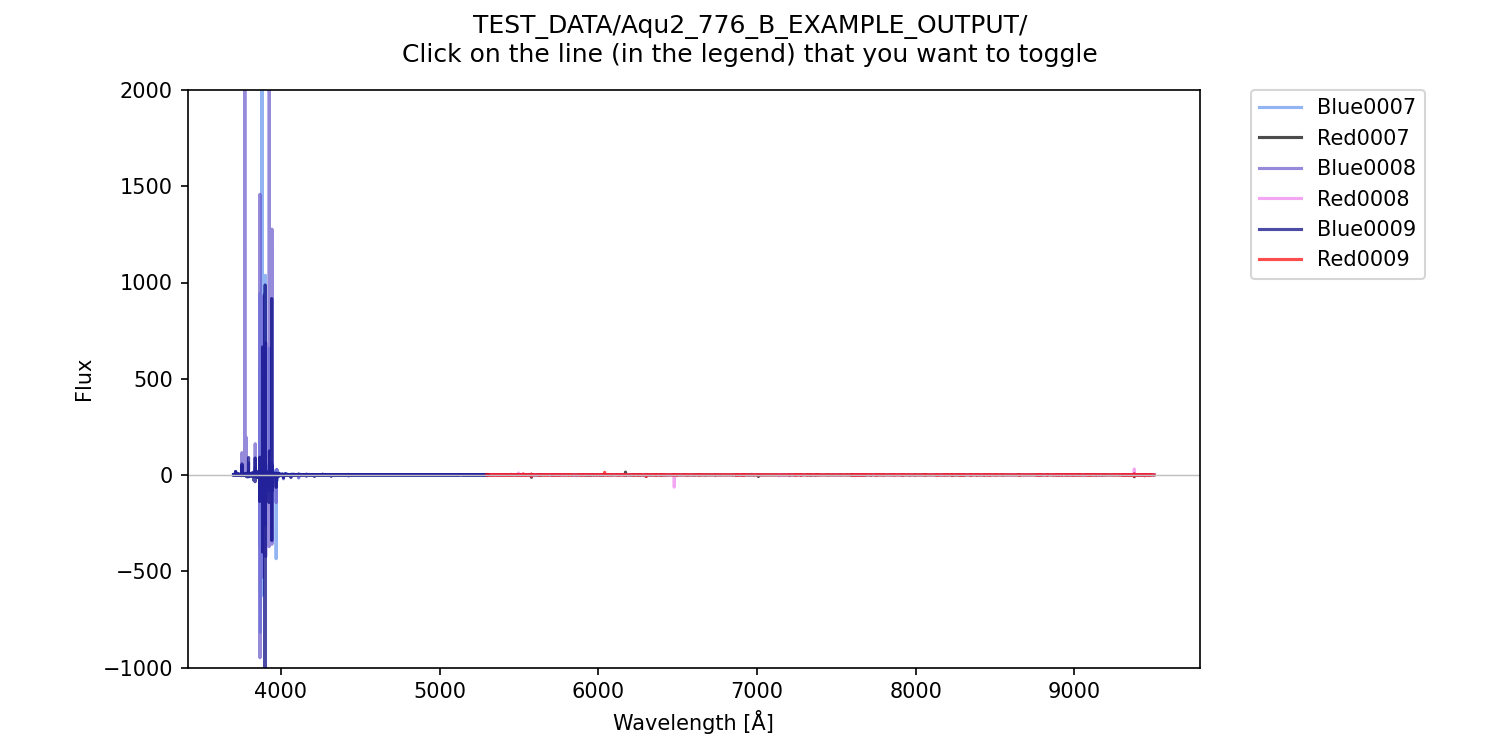

In [21]:
def plot_exposures(choice):
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(111)
    x = np.linspace(3500, 9500)

    red_colors = ['k','violet','red','maroon']
    blue_colors = ['cornflowerblue','slateblue','navy','cyan']

    count_red = 0
    count_blue = 0
    for i in range(len(exposures)):
        if choice == 'dat':
            spectrum = np.genfromtxt(dir_name + star + '/' + exposures[i], dtype = None, encoding = None, names = True, skip_header=1)
        elif choice == 'xyz':
            spectrum = np.genfromtxt(dir_name + star + '/' + exposures[i], dtype = None, encoding = None, names = True, skip_header=0)
        
        if 'red' in exposures[i]: 
            color = red_colors[count_red]
            name = 'Red' + exposures[i][10:14]
            count_red+=1
        elif 'blue' in exposures[i]:
            color = blue_colors[count_blue]
            name = 'Blue' + exposures[i][10:14]
            count_blue+=1

        if choice == 'dat':
            ax.plot(spectrum['wavelength'],spectrum['data'],c=color,alpha=0.7,label=name)
        elif choice == 'xyz':
            ax.plot(spectrum['wavelength'],spectrum['flux'],c=color,alpha=0.7,label=name)
        
    return fig, ax

def main(choice):
    fig, ax = plot_exposures(choice)

    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Flux')

    ax.axhline(1, c='silver', linewidth=0.7)

    ax.set_ylim(-1000,2000)
    
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1),
              ncol=1, borderaxespad=0)
    fig.subplots_adjust(right=0.8)
    fig.suptitle(f'{star}\nClick on the line (in the legend) that you want to toggle',
                 va='top', size='large')

    leg = interactive_legend()
    return fig, ax, leg

def interactive_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    if ax.legend_ is None:
        ax.legend()

    return InteractiveLegend(ax.get_legend())

class InteractiveLegend(object): 
    def __init__(self, legend):
        self.legend = legend
        self.fig = legend.axes.figure

        self.lookup_artist, self.lookup_handle = self._build_lookups(legend)
        self._setup_connections()

        self.update()

    def _setup_connections(self):
        for artist in self.legend.texts + self.legend.legend_handles:
            artist.set_picker(10) # 10 points tolerance

        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def _build_lookups(self, legend):
        labels = [t.get_text() for t in legend.texts]
        handles = legend.legend_handles
        label2handle = dict(zip(labels, handles))
        handle2text = dict(zip(handles, legend.texts))

        lookup_artist = {}
        lookup_handle = {}
        for artist in legend.axes.get_children():
            if artist.get_label() in labels:
                handle = label2handle[artist.get_label()]
                lookup_handle[artist] = handle
                lookup_artist[handle] = artist
                lookup_artist[handle2text[handle]] = artist

        lookup_handle.update(zip(handles, handles))
        lookup_handle.update(zip(legend.texts, handles))

        return lookup_artist, lookup_handle

    def on_pick(self, event):
        handle = event.artist
        if handle in self.lookup_artist:

            artist = self.lookup_artist[handle]
            artist.set_visible(not artist.get_visible())
            self.update()

    def on_click(self, event):
        ## Uncomment if you want to allow middle-click & right-click to toggle all lines at once
#         if event.button == 3: 
#             visible = False
#         elif event.button == 2:
#             visible = True
#         else:
#             return

        for artist in self.lookup_artist.values():
            artist.set_visible(visible)
        self.update()

    def update(self):
        for artist in self.lookup_artist.values():
            handle = self.lookup_handle[artist]
            if artist.get_visible():
                handle.set_visible(True)
            else:
                handle.set_visible(False)
        self.fig.canvas.draw()

    def show(self):
        plt.show()

if __name__ == '__main__':
    print('Un-processed data is .dat, normalized and corrected data is .xyz')
    choice = input('Type either: dat or xyz for file to plot')
    
    valid = True
    if choice not in ['dat', 'xyz']:
        print('Sorry, invalid file type')
        valid = False
        
    if valid == True:
        dir_list = os.listdir(dir_name + star)
        exposures = []
        for file in dir_list:
            if choice == 'dat':
                if '.dat' in file:
                    exposures.append(file)
            if choice == 'xyz':
                if 'normrv.xyz' in file:
                    exposures.append(file)
        
        exposures.sort()
        print(*exposures, sep='\n')
        
        fig, ax, leg = main(choice)
        plt.show()
    
